## Image-Sweep

### Dataset preperation

In [725]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import pandas as pd

import time
import PIL.Image as Image
from IPython.display import Image, display
import matplotlib.cm as cm

# Data Augmentation

In [726]:
with tf.device('/cpu:0'): #this line is essential only if you are using a M1 Processor
    data_augmentation = tf.keras.Sequential([
      tf.keras.layers.RandomFlip('horizontal_and_vertical'),
      tf.keras.layers.RandomRotation(0.2),
      tf.keras.layers.RandomZoom(0.1),
      #tf.keras.layers.RandomCrop(1024, 1024),
    ])

In [727]:
#img =  tf.keras.utils.load_img('screenshot.png')
#img = tf.expand_dims(img, 0)

In [728]:
#with tf.device('/cpu:0'):
#    plt.figure(figsize=(15, 15))
#    for i in range(9):
#      augmented_image = data_augmentation(img)
#      ax = plt.subplot(3, 3, i + 1)
#      plt.imshow(augmented_image[0] / 255)
#      plt.axis("off")

In [729]:
directory = "data/"

BATCH_SIZE = 32
IMG_SIZE = (192, 192)

train_dataset = tf.keras.utils.image_dataset_from_directory(directory,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True,
                                                            seed=999,
                                                            validation_split=0.20,
                                                            subset = "training")

validation_dataset = tf.keras.utils.image_dataset_from_directory(directory,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True,
                                                            seed=999,
                                                            validation_split=0.20,
                                                            subset = "validation")

Found 78 files belonging to 2 classes.
Using 63 files for training.
Found 78 files belonging to 2 classes.
Using 15 files for validation.


2024-05-11 16:57:10.707101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


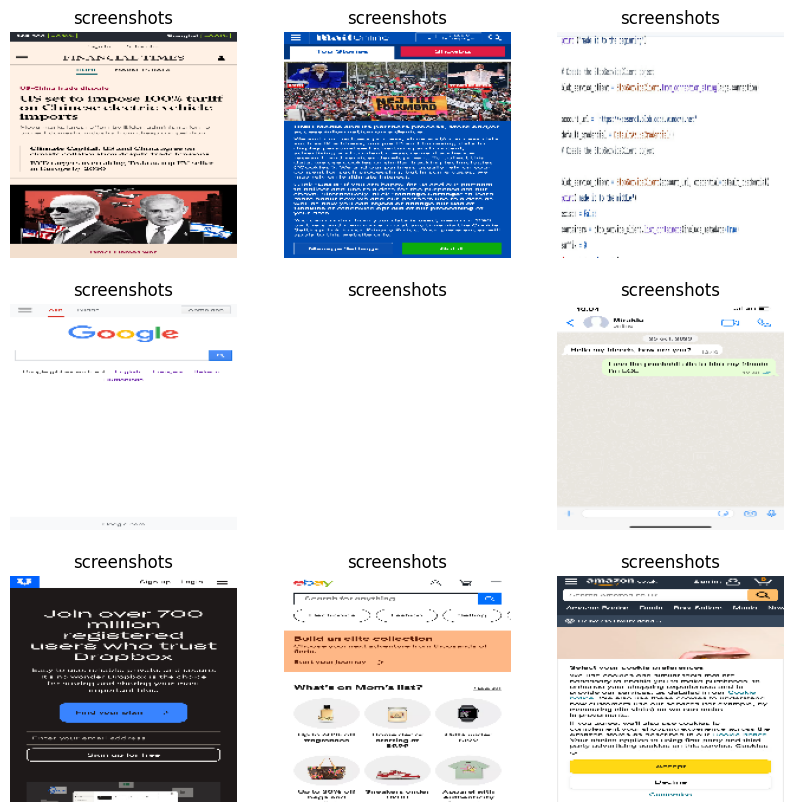

In [730]:
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [731]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
#test_dataset = validation_dataset.take(val_batches // 5)
test_dataset = validation_dataset.take(val_batches // 1)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 1
Number of test batches: 1


In [732]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [733]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [734]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [735]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


In [736]:
base_model.trainable = False

In [737]:
#base_model.summary()

In [738]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(2, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

In [739]:
base_learning_rate = 0.0001

outputs = tf.keras.layers.Dense(2, activation="softmax")(x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [740]:
model.summary()

Model: "functional_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_168 (InputLayer)    │ (None, 192, 192, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_34 (Sequential)      │ (None, 192, 192, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_192            │ (None, 6, 6, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_16     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [741]:
initial_epochs = 50

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.2084
initial loss: 0.21
initial accuracy: 1.00


In [742]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9790 - loss: 0.1404 - val_accuracy: 1.0000 - val_loss: 0.1781
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9894 - loss: 0.1033 - val_accuracy: 1.0000 - val_loss: 0.1528
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 1.0000 - loss: 0.1194 - val_accuracy: 1.0000 - val_loss: 0.1309
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9578 - loss: 0.1366 - val_accuracy: 1.0000 - val_loss: 0.1119
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 1.0000 - loss: 0.0746 - val_accuracy: 1.0000 - val_loss: 0.0960
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 1.0000 - loss: 0.0980 - val_accuracy: 1.0000 - val_loss: 0.0825
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 1.0000 - loss: 0.0667 - val_accuracy: 1.0000 - val_loss: 0.0712
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 1.0000 - loss: 0.0515 - val_accuracy: 1.0000 - val_loss: 0.0620
Epoch 9/50
2/2 ━

KeyboardInterrupt: 

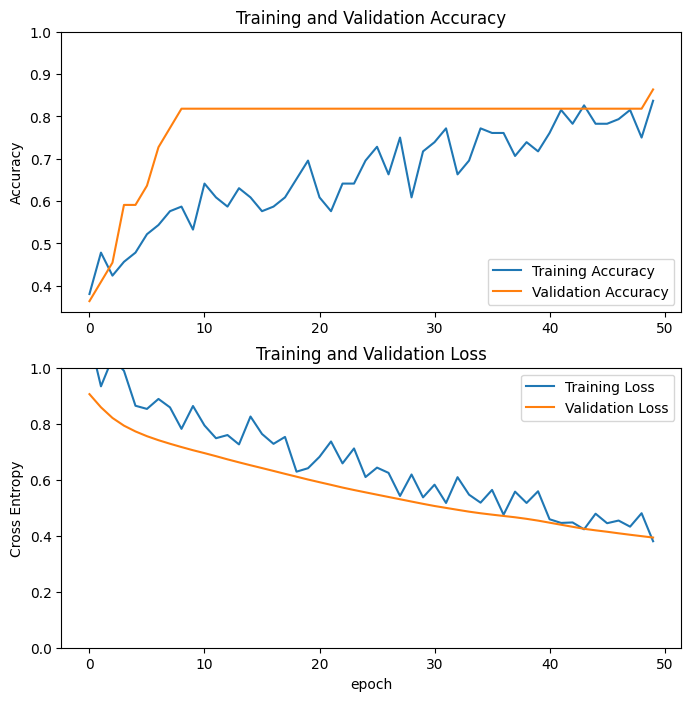

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.8636 - loss: 0.3935
Test accuracy : 0.8636363744735718


Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0]
Labels:
 [1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0]


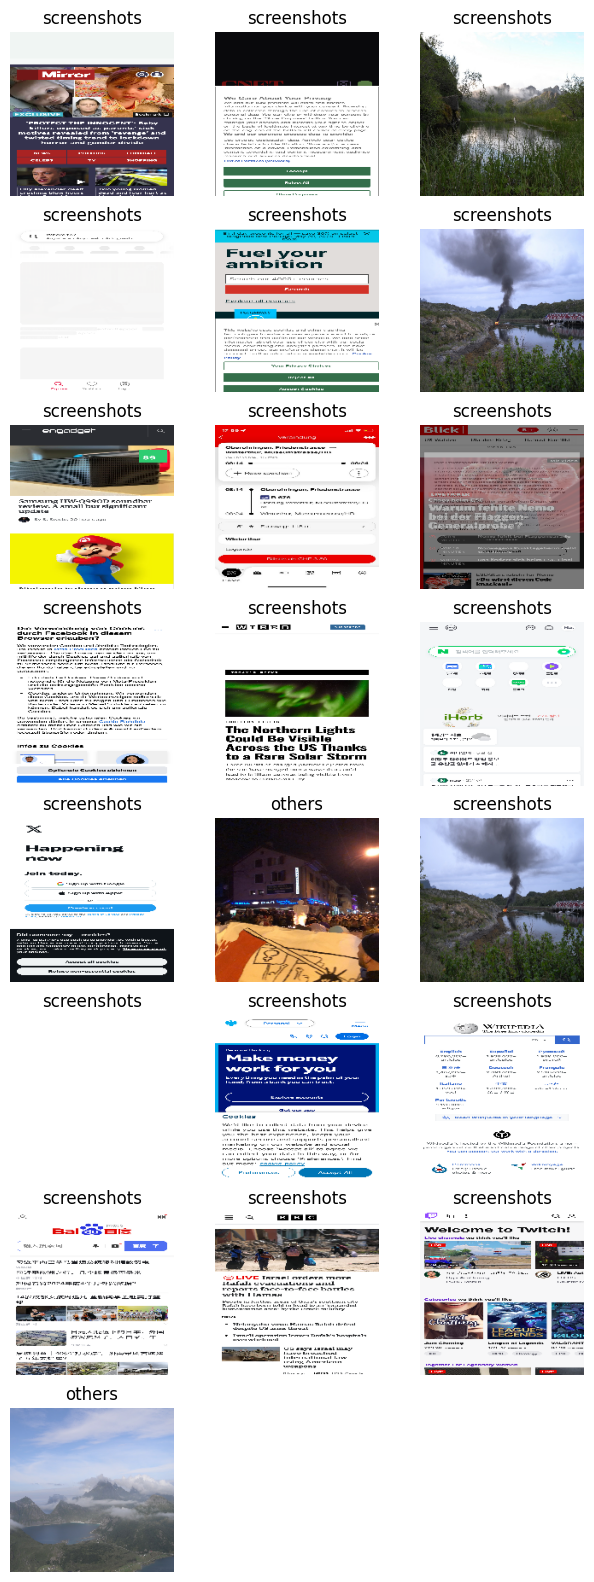

In [ ]:
import math

# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

# Get model predictions. Note: Do not flatten here.
predictions = model.predict_on_batch(image_batch)

# Apply tf.argmax to get the predicted class indices directly
predicted_class_indices = tf.argmax(predictions, axis=-1)

print('Predictions:\n', predicted_class_indices.numpy())
print('Labels:\n', label_batch)

# Plot the images and predicted labels
batch_size = image_batch.shape[0]  # Get the actual batch size
num_columns = 3  # Define the number of columns you want
num_rows = math.ceil(batch_size / num_columns)  # Calculate the number of rows needed

plt.figure(figsize=(2.5 * num_columns, 2.5 * num_rows))  # Adjust the figure size appropriately
for i in range(batch_size):
    ax = plt.subplot(num_rows, num_columns, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predicted_class_indices[i]])
    plt.axis("off")
plt.show()




This image most likely belongs to screenshots.


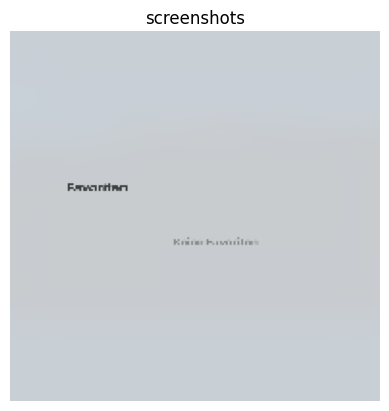

In [ ]:
img = tf.keras.utils.load_img("examples/screenshot2.png", target_size=(192,192)# your own image
)

# Ensure you're adding the image to a batch where it's the only member.
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

# Get model predictions. Note: No need to flatten.
prediction = model.predict_on_batch(img_array)

# Get the index of the maximum value in each prediction vector (highest probability)
predicted_class_index = tf.argmax(prediction, axis=-1)

print(
    "This image most likely belongs to {}.".format(class_names[predicted_class_index.numpy()[0]])
)

plt.imshow(img)
plt.title(class_names[predicted_class_index.numpy()[0]])
plt.axis("off")
plt.show()
